# First 2000-volume sample of fiction

This is straightforward, but I'm going to walk through it slowly to demonstrate different approaches one can use in basic Python and in Pandas.

In [5]:
# first, we "import" some modules we'll be using

import pandas as pd
import random

Now actually read in the metadata.

In [3]:
meta = pd.read_csv('../workmeta.tsv', sep = '\t', low_memory = False)
meta.head()

,docid,oldauthor,author,authordate,inferreddate,latestcomp,datetype,startdate,enddate,imprint,...,recordid,instances,allcopiesofwork,copiesin25yrs,enumcron,volnum,title,parttitle,earlyedition,shorttitle
0,mdp.39015031913893,"Spencer, Louise Reid","Spencer, Louise Reid",NaN,0,2100,|,||||,||||,Thomas Y. Crowell company|1945,...,8744,1,1,1,NaN,NaN,Guerrilla wife | $c: [by] Louise Reid Spencer.,NaN,True,Guerrilla wife
1,mdp.39015003936864,"Baker, Robert H","Baker, Robert H",NaN,0,2100,n,,,"Port Washington, N.Y.|Ashley Books|197-?].",...,39757,1,1,1,NaN,NaN,The suburbs : | a novel / | $c: by Robert H. B...,NaN,True,The suburbs : a novel
2,mdp.39015068342305,"Dickens, Charles","Dickens, Charles",1812-1870.,0,1870,n,,,New York|The American news company|n.d.,...,119996,1,1,1,NaN,NaN,Edwin Drood. | $c: By Charles Dickens. With il...,NaN,True,Edwin Drood
3,mdp.39015055066586,"Stretton, Hesba","Stretton, Hesba",1832-1911.,0,1911,n,,,"New York|Dodd, Mead & co.|n.d.",...,122460,1,1,1,NaN,NaN,"Carola, | $c: by Hesba Stretton.",NaN,True,Carola
4,mdp.39015055066594,"Stretton,Hesba","Stretton, Hesba",1832-1911.,0,1911,n,,,"New York|Dodd, Mead & co.|n.d.",...,122464,1,1,1,NaN,NaN,In prison & out. | $c: By Hesba Stretton.,NaN,True,In prison & out


In [4]:
meta.shape


(138137, 28)

That tells us we have 138,137 rows and 28 columns in the dataset.

In [5]:
meta.columns

Index(['docid', 'oldauthor', 'author', 'authordate', 'inferreddate',
       'latestcomp', 'datetype', 'startdate', 'enddate', 'imprint',
       'imprintdate', 'contents', 'genres', 'subjects', 'geographics',
       'locnum', 'oclc', 'place', 'recordid', 'instances', 'allcopiesofwork',
       'copiesin25yrs', 'enumcron', 'volnum', 'title', 'parttitle',
       'earlyedition', 'shorttitle'],
      dtype='object')

Let's count the number of volumes that have "earlyedition" flagged.

To start with, I'll do it in the ordinary Python way we practiced earlier.

In [8]:
ctr = 0
for value in meta.earlyedition:
    if value == True:
        ctr += 1
print(ctr)

129023


But there's a simpler way to do that. If you sum a list of Boolean (True/False) values, you get a count of the number of Trues. So, just:

In [9]:
print(sum(meta.earlyedition))

129023


In any case, this tells us that only about 129,000 of our 138,000 volumes were printed within 25 years of their author's death. I'm going to sample randomly from that group. In fact, if it were possible, I'd restrict even further to books printed within 25 years of the first publication *of that title.* But we don't always directly know a first publication date.

### Actually sampling

I want to get 100 novels for each decade between 1800-09 and 2000-09. So, let's say 10 volumes a year. But I'm also conscious that we'll be rejecting a lot of books. So I'm going to initially sample 13 volumes a year, with the expectation that almost a third will be rejected.

There are easy pandas-specific ways to do this. But I want to demonstrate Python logic, so I'm going to avoid easy things that look like magic tricks and do this a more laborious way.

Let's just go through the whole dataset row by row and check the **document ID** and **date of publication.** If the date is between 1800 and 2010, we'll save the document ID and file it in a dictionary (set of file drawers) where the key for each drawer is a particular year, and the contents of each drawer are a list of doc IDs.

Then, once we've got the volumes sorted in this manner by date, we can randomly sample 13 volumes from each drawer.

In [11]:
# To go through a pandas dataframe row by row, you can use the .iterrows() method.

bydate = dict()
# create the dictionary

for idx, row in meta.iterrows():
    date = row.inferreddate
    docid = row.docid
    early = row.earlyedition
    
    if early == False:
        continue
        # we're not going to use rows that aren't marked earlyedition
        # so we "continue" to the next iteration of the loop, and don't
        # do anything below
    
    else:
        if date < 1800 or date > 2009:
            continue
        else:
            
            if date not in bydate:
                # if we haven't encountered any volumes with this date yet,
                # create a list with one member
                bydate[date] = [docid]
            else:
                # otherwise, add this docid to the existing list
                bydate[date].append(docid)
        

#### A little visualization

What's the date distribution of these volumes, by the way?

We can find out by counting the number of volumes in each "file drawer."

First we'll import a modules that's useful for plotting graphs. Then we'll go year by year from 1800 to 2009. We'll create a list of x coordinates that is simply the list of years, and a list of y coordinates that is the number of volumes in that year. The we just scatter plot (x, y).

In [12]:
from matplotlib import pyplot as plt
%matplotlib inline

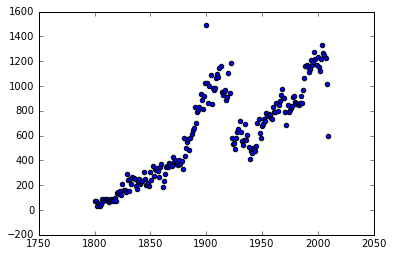

In [13]:
x = []
y = []
for year in range(1800, 2010):
    x.append(year)
    y.append(len(bydate[year]))
plt.scatter(x, y)
plt.show()

You can see that the advent of copyright at 1923 makes a big difference in the size of the collection. I'm not exactly sure why; our collection is not limited to public-domain works. But possibly libraries have been less enthusiastic about digitizing fiction when it can't be made publicly available.

We're going to flatten that out and select an evenly-distributed sample.

#### okay, let's finally select volumes

I'm going to go year by year. From the file drawer for each year (```bydate[year]```) I'm going to draw thirteen books.

Then I'll add them to a constantly-growing list called ```selected.```

Notice how this echoes the counting strategy. Create a counter outside the loop; set it to zero; then loop through a sequence and add one to the counter ... Here we're extending a list instead of adding to a counter.

In [14]:
selected = list()

for yr in range(1800, 2010):
    selected.extend(random.sample(bydate[yr], 13))

print(len(selected))

2730


Once we have a list of document ids we want to select, we can use them to extract the relevant rows from the table ```meta.```

In [15]:
# To create a table limited to those document ids, we can just use the "docid"
# column to *index* meta

meta.set_index('docid', inplace = True)

# and then select those rows

our_meta = meta.loc[selected, : ]
our_meta.shape

(2730, 27)

Now actually write that to disk.

In [16]:
our_meta.to_csv('firstsample.tsv', sep = '\t')

But in exploring this data with you, I quickly found that 28 full-width columns are overwhelming. So let's select a smaller set of twelve columns, and truncate some of them at 25 or 50 characters.

In [47]:
def truncate25(afield):
    if pd.isnull(afield):
        return ''
    elif len(afield) <= 25:
        return afield
    else:
        return afield[0:25]

def shrinkframe(indf):
    df = indf.copy()
    df.reset_index(inplace = True)
    newdf = df[['docid', 'author', 'authordate', 'inferreddate', 'latestcomp', 'allcopiesofwork', 'copiesin25yrs', 'enumcron']]
    newdf = newdf.assign(imprint = df.imprint.map(truncate25))
    newdf = newdf.assign(genres = df.genres.map(truncate25))
    newdf = newdf.assign(subjects = df.subjects.map(truncate25))
    newdf = newdf.assign(shorttitle = df.shorttitle)
    newdf = newdf.assign(realname = '')
    newdf = newdf.assign(pseudonym = '')
    newdf = newdf.assign(category = '')
    newdf = newdf.assign(firstpub = '')
    newdf = newdf.assign(realname = '')
    newdf = newdf.assign(gender = '')
    newdf = newdf.assign(nationality = '')
    newdf = newdf[['docid', 'author', 'realname', 'pseudonym', 'gender', 'nationality', 'authordate', 
                   'inferreddate', 'firstpub', 'latestcomp', 'allcopiesofwork', 'copiesin25yrs',
                   'enumcron', 'imprint', 'genres', 'subjects', 'category', 'shorttitle']]
    
    return newdf

shrunk = shrinkframe(our_meta)
print(shrunk.shape)
shrunk.head()

(2730, 18)


,docid,author,realname,pseudonym,gender,nationality,authordate,inferreddate,firstpub,latestcomp,allcopiesofwork,copiesin25yrs,enumcron,imprint,genres,subjects,category,shorttitle
0,nyp.33433074911573,"Smith, Charlotte Turner",,,,,1749-1806.,1800,,1800,1,1,v. 4,London;Printed by and for,Fiction,English fiction,,The Hungarian
1,nyp.33433074911581,"Smith, Charlotte Turner",,,,,1749-1806.,1800,,1800,1,1,v. 5,London;Printed by and for,Fiction,English fiction,,The Hungarian (con't.) Leonora. Guilelmine de...
2,njp.32101037604772,"Du Bois, Edward",,,,,1774-1850.,1800,,1800,1,1,NaN,London;Printed for J. Wri,Fiction,"Godwin, William|1756-1836",,"St. Godwin: a tale of the sixteenth, seventeen..."
3,hvd.hn2he3,"Kendall, Edward Augustus",,,,,1776?-1842.,1800,,1800,1,1,NaN,London;Printed for E. New,Juvenile audience|Fiction,Conduct of life|Children',,"The stories of Senex, or, Little histories of ..."
4,hvd.hn2he5,NaN,,,,,NaN,1800,,1800,1,1,NaN,London;Printed for Vernor,Fiction,,,"The Governess, or, Evening amusements at a boa..."


Now we need to divide this dataframe into three parts for the three of us. I'm giving 1200 rows to both of you, and taking 330 rows for myself as a sample, so I know what kind of problems you're encountering.

#### divide in three parts

We start by shuffling the index of our_meta, which is just a numeric index right now.

In [37]:
indices = our_meta.index.tolist()
random.shuffle(indices)
indices[0:20]

[2230,
 241,
 61,
 1823,
 559,
 1494,
 344,
 994,
 72,
 1604,
 713,
 29,
 721,
 2311,
 2006,
 1244,
 506,
 1890,
 1412,
 1582]

Then divide that random sequence into chunks like so:

In [38]:
forjessica = indices[0: 1200]
forpatrick = indices[1200: 2400]
forted = indices[2400 : ]

In [48]:
teddf = shrinkframe(our_meta.loc[forted, ])
teddf.to_csv('ted.tsv', sep = '\t', index = False)

In [49]:
jessdf = shrinkframe(our_meta.loc[forjessica, ])
jessdf.to_csv('jessica.tsv', sep = '\t', index = False)

In [50]:
patdf = shrinkframe(our_meta.loc[forpatrick, ])
patdf.to_csv('patrick.tsv', sep = '\t', index = False)

### Sanity checks

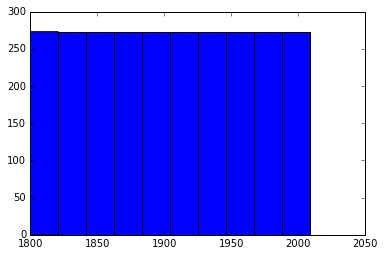

In [51]:
plt.hist(our_meta.inferreddate)
plt.show()

Good. even distribution across time

In [52]:
max(our_meta.inferreddate)

2009

In [53]:
min(our_meta.inferreddate)

1800